In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston, load_iris
from sklearn.preprocessing import PolynomialFeatures

## Loading datasets
We begin by loading both the Boston and Iris datasets. More information about the Boston dataset can be found [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) and more information about the Iris dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/iris). Do not change the cell below this one.

In [2]:
# Define a random state for reproducibility.
random_state = np.random.RandomState(0)

# Load and shuffle the Boston dataset. Only subsample some features.
boston_X, boston_y = load_boston(return_X_y=True)
permutation = random_state.permutation(boston_X.shape[0])
boston_X = boston_X[permutation][:, [5, 6]]
boston_y = boston_y[permutation]

# Split the dataset into train and test sets.
boston_X_train = boston_X[:-100]
boston_y_train = boston_y[:-100]
boston_X_test = boston_X[-100:]
boston_y_test = boston_y[-100:]

# Create a new featurization for the boston dataset by turning the current
# features into a tenth degree polynomial.
boston_poly_X_train = PolynomialFeatures(8).fit_transform(boston_X_train)
boston_poly_X_test = PolynomialFeatures(8).fit_transform(boston_X_test)

# Now load and shuffle the Iris dataset.
# Discarding all output labels that correspond to a 2.
iris_X, iris_y = load_iris(return_X_y=True)
iris_X = iris_X[:100]
iris_y = iris_y[:100]
permutation = random_state.permutation(iris_X.shape[0])
iris_X = iris_X[permutation]
iris_y = iris_y[permutation]

# Split the dataset into train and test sets.
iris_X_train = iris_X[:-20]
iris_y_train = iris_y[:-20]
iris_X_test = iris_X[-20:]
iris_y_test = iris_y[-20:]

## Regression and Prediction functions
We now define the regression and prediction functions. You need to fill these out, we provide `logistic_cross_entropy_loss_gradient` as an example.

Remember that the squared loss (with regularization) with respect to linear regression is defined as $\|X\beta - y\|_2^2 + \lambda \|\beta\|_2^2$ where $\beta$ is the linear model, $X$ is the feature matrix, $\lambda$ is a regularization term, and $y$ are the true output values. Furthermore remember that the derivative of $\|X\beta - y\|_2^2$ with respect to $\beta$ is $2X^{\top}(X\beta - y)$ and the derivative of $\lambda \|\beta\|_2^2$ is $2\lambda \beta$.

The cross entropy loss with respect to logistic regression is defined as $-\frac{1}{n} \sum_{i=1}^n \left[y_i \log \sigma(x_i^{\top}\beta) + (1 - y_i)\log\sigma(-x_i^{\top}\beta)\right]$.

In [3]:
def regression_predict(X, beta):
    """Given a linear model (aka a vector) and a feature matrix
    predict the output vector.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    
    Returns
    -------
    y : numpy array of shape n
        The predicted output vector.
    """
    # TODO: Fill in (Q2b)
    return X @ beta

def regression_least_squares(X, true_y, lambda_value):
    """Compute the optimal linear model that minimizes the regularized squared loss.

    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    true_y : numpy array of shape n
        The true output vector.
    lambda_value : float
        A non-negative regularization term.
    
    Returns
    -------
    beta : numpy array of shape d
        The optimal linear model.
    """
    n = X.shape[0]
    d = X.shape[1]
    inv_term = np.linalg.inv((X.T @ X)/n + lambda_value * np.identity(d))
    next_term =  X.T @ true_y /n
    return inv_term @ next_term


In [4]:
regression_least_squares(iris_X_train, iris_y_train, 0.01)

array([ 0.01444146, -0.13028296,  0.23174124,  0.20650694])

In [5]:
def sigmoid(x):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-x))

def logistic_predict(X, beta):
    """Given a linear model (aka a vector) and a feature matrix
    predict the probability of the output label being 1 using logistic
    regression.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    
    Returns
    -------
    y : numpy array of shape n
        The predicted output vector.
    """
    # TODO: Fill in (Q2b)
    return sigmoid(X @ beta)
    

def logistic_cross_entropy_loss(X, beta, true_y):
    """Output the cross entropy loss of a given logistic model.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    true_y : numpy array of shape n
        The true output vectors. Consists of 0s and 1s.
        
    Returns
    -------
    loss : float
        The value of the loss.
    """
    return -1/len(true_y) * np.sum(true_y*np.log(sigmoid(X @ beta)) + (1-true_y) * np.log(sigmoid(-X@beta)))

def logistic_cross_entropy_loss_gradient(X, beta, true_y):
    """Output the gradient of the squared loss evaluated with respect to beta.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    beta : numpy array of shape d
        The linear model.
    true_y : numpy array of shape n
        The true output vectors.
        
    Returns
    -------
    loss_gradient : numpy array of shape d
        The gradient of the loss evaluated with respect to beta.
    """
    return -np.sum((true_y - sigmoid(X @ beta)) * X.T, axis=1) / X.shape[0]

In [6]:
x = iris_X_train
true_y = iris_y_train
logistic_cross_entropy_loss(x, regression_least_squares(x, true_y, 0.01), true_y)

0.52107428943243517

In [7]:
def gradient_descent(X, init_beta, true_y, loss, loss_gradient,
                     learning_rate, iterations):
    """Performs gradient descent on a given loss function and
    returns the optimized beta.
    
    Parameters
    ----------
    X : numpy array of shape nxd
        The feature matrix where each row corresponds to a single
        feature vector.
    init_beta : numpy array of shape d
        The initial value for the linear model.
    true_y : numpy array of shape n
        The true output vectors.
    loss : function
        The loss function we are optimizing.
    loss_gradient : function
        The gradient function that corresponds to the loss function.
    learning_rate : float
        The learning rate for gradient descent.
    iterations : int
        The number of iterations to optimize the loss for.

    Returns
    -------
    beta : numpy array of shape d
        The optimized beta.
    """
    beta = init_beta
    for i in range(iterations):
        gradient = loss_gradient(X, beta, true_y)
        new_beta = beta - learning_rate * gradient
        if abs(new_beta[0] - beta[0]) < 0.001:
            print("iteration", i)
            return new_beta
        beta = new_beta
    return new_beta

In [8]:
## testing gradient_descent

X = iris_X_train
true_y = iris_y_train
init_beta = regression_least_squares(X, true_y, 0.01)
learning_rate = 0.2
iterations = 1000

gradient_descent(X, init_beta, true_y, logistic_cross_entropy_loss, logistic_cross_entropy_loss_gradient, learning_rate, iterations)

iteration 122


array([-0.41649302, -1.46333194,  2.14453759,  1.04725936])

## Training models for the Boston dataset
In the section below you will train a regression model and evaluate it against the RMSE for the Boston housing dataset we created above.

In [9]:
## RMSE function

def RMSE(preds, true_y):
    RMSE = np.sqrt((1/len(true_y) * np.sum((true_y - preds)**2))) 
    return RMSE

In [36]:

# RMSE for Boston Housing Datase
x_train = boston_X_train
x_test= boston_X_test

lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]
rmse_vals = []

for i in range(len(lambdas)):
    beta = regression_least_squares(x_train,boston_y_train,lambdas[i])
    pred = regression_predict(x_test, beta)
    rmse_vals += [RMSE(pred, boston_y_test)]
    
rmse_vals

[6.6563463275551848,
 6.6563817002689527,
 6.6567002481403614,
 6.6599048020484881,
 6.6937834263964371,
 7.1557274608771735,
 11.098618724445203]

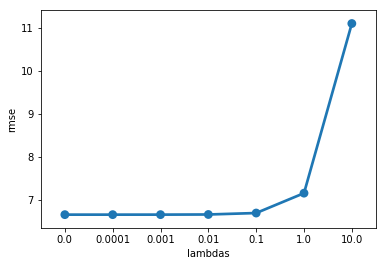

In [37]:
d = pd.DataFrame(data={'lambdas': lambdas, 'rmse': rmse_vals})
sns.pointplot(x='lambdas', y='rmse', data=d)
plt.show()

In [38]:
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]
rmse_vals = []

for i in range(len(lambdas)):
    beta = regression_least_squares(boston_poly_X_train, boston_y_train,lambdas[i])
    pred = regression_predict(boston_poly_X_test, beta)
    rmse_vals += [RMSE(pred, boston_y_test)]
    
rmse_vals

[16.48584680844737,
 5.4658120765808373,
 5.082927772023984,
 4.965830778537021,
 4.9103477010684395,
 4.9201698739985309,
 4.9204280221606274]

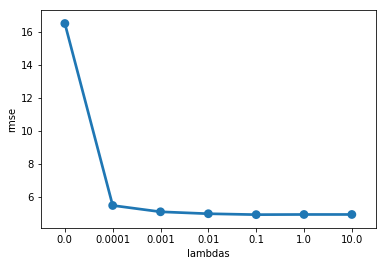

In [39]:
d = pd.DataFrame(data={'lambdas': lambdas, 'rmse': rmse_vals})
sns.pointplot(x='lambdas', y='rmse', data=d)
plt.show()

### 2d: Written response

The value of regularization term did matter for both featurizations, in different ways.
The second featurization performed better because the RMSE was lower overall.

## Training model for the logistic regression dataset
In this section you will train a logistic model and evaluate it against the MAE for the Iris dataset we created above.

In [62]:
# TODO: Fill in (Q2f)
def MAE(preds, true_y):
    mae = np.sum(np.absolute((true_y - preds)))
    return mae


# Traiing logistic regression
# Use gradient descent to find betas
# Use betas in logistic predict

MAE_vals = []
init_beta = regression_least_squares(iris_X_train, iris_y_train, 10) ### CHECK

betas = gradient_descent(iris_X_train, init_beta, iris_y_train, logistic_cross_entropy_loss, 
                        logistic_cross_entropy_loss_gradient, 0.1, 100)

preds = logistic_predict(iris_X_test, betas)

converted=[]

for pred in preds:
    if pred>= 0.5:
        converted+=[1]
    else:
        converted+=[0]
    
mae= np.mean(abs(converted-iris_y_test))
mae
    


0.0

In [ ]:
#